In [ ]:
!git clone https://github.com/jliu1118/data.git

Cloning into 'data'...
remote: Enumerating objects: 15752, done.
remote: Total 15752 (delta 0), reused 0 (delta 0), pack-reused 15752
Receiving objects: 100% (15752/15752), 198.19 MiB | 14.99 MiB/s, done.
Checking out files: 100% (15749/15749), done.


In [ ]:
!ls


data  sample_data


In [ ]:
!ls data

driving_log.csv  IMG


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.image as mpimg
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
import ntpath
import os

In [ ]:
datadir = '/content/data/'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,/Users/jeremy/Desktop/data/IMG/center_2021_05_24_16_31_48_575.jpg,/Users/jeremy/Desktop/data/IMG/left_2021_05_24_16_31_48_575.jpg,/Users/jeremy/Desktop/data/IMG/right_2021_05_24_16_31_48_575.jpg,0.0,0.0,0.0,0.000079
1,/Users/jeremy/Desktop/data/IMG/center_2021_05_24_16_31_48_676.jpg,/Users/jeremy/Desktop/data/IMG/left_2021_05_24_16_31_48_676.jpg,/Users/jeremy/Desktop/data/IMG/right_2021_05_24_16_31_48_676.jpg,0.0,0.0,0.0,0.000078
2,/Users/jeremy/Desktop/data/IMG/center_2021_05_24_16_31_48_779.jpg,/Users/jeremy/Desktop/data/IMG/left_2021_05_24_16_31_48_779.jpg,/Users/jeremy/Desktop/data/IMG/right_2021_05_24_16_31_48_779.jpg,0.0,0.0,0.0,0.000078
3,/Users/jeremy/Desktop/data/IMG/center_2021_05_24_16_31_48_882.jpg,/Users/jeremy/Desktop/data/IMG/left_2021_05_24_16_31_48_882.jpg,/Users/jeremy/Desktop/data/IMG/right_2021_05_24_16_31_48_882.jpg,0.0,0.0,0.0,0.000080
4,/Users/jeremy/Desktop/data/IMG/center_2021_05_24_16_31_48_984.jpg,/Users/jeremy/Desktop/data/IMG/left_2021_05_24_16_31_48_984.jpg,/Users/jeremy/Desktop/data/IMG/right_2021_05_24_16_31_48_984.jpg,0.0,0.0,0.0,0.000082


In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_05_24_16_31_48_575.jpg,left_2021_05_24_16_31_48_575.jpg,right_2021_05_24_16_31_48_575.jpg,0.0,0.0,0.0,0.000079
1,center_2021_05_24_16_31_48_676.jpg,left_2021_05_24_16_31_48_676.jpg,right_2021_05_24_16_31_48_676.jpg,0.0,0.0,0.0,0.000078
2,center_2021_05_24_16_31_48_779.jpg,left_2021_05_24_16_31_48_779.jpg,right_2021_05_24_16_31_48_779.jpg,0.0,0.0,0.0,0.000078
3,center_2021_05_24_16_31_48_882.jpg,left_2021_05_24_16_31_48_882.jpg,right_2021_05_24_16_31_48_882.jpg,0.0,0.0,0.0,0.000080
4,center_2021_05_24_16_31_48_984.jpg,left_2021_05_24_16_31_48_984.jpg,right_2021_05_24_16_31_48_984.jpg,0.0,0.0,0.0,0.000082


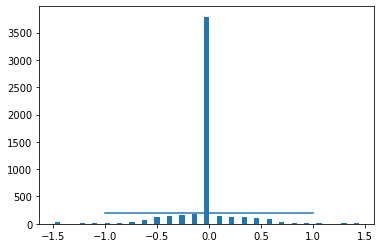

In [ ]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1])+bins[1:] * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:

remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

3590
1659


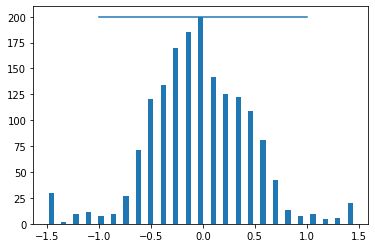

In [ ]:
print(len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print(len(data))
hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_path = np.asarray(image_path)
  steering = np.asarray(steering)
  return image_path, steering
image_paths, steerings = load_img_steering(datadir+'/IMG', data)

center      center_2021_05_24_16_31_50_523.jpg
left        left_2021_05_24_16_31_50_523.jpg  
right       right_2021_05_24_16_31_50_523.jpg 
steering   -0.0849273                         
throttle    1                                 
reverse     0                                 
speed       5.79122                           
Name: 19, dtype: object


Text(0.5, 1.0, 'Validation set')

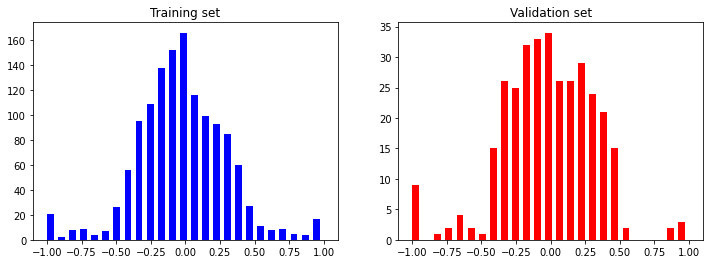

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')

axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [ ]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img / 255 #normalizing
  return img

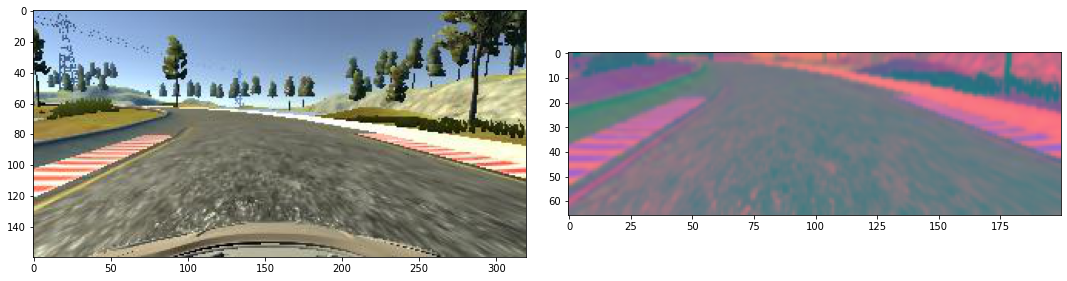

In [ ]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[1].imshow(preprocessed_image)

In [ ]:
#prepross training data
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))


(1327, 66, 200, 3)


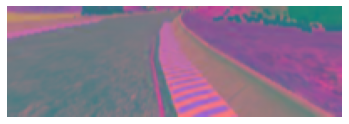

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [ ]:
def nvidia_model():
 
  model = Sequential()
  
  model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))
  
  model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Dropout(0.5))
  
  
  model.add(Flatten())

  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation ='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))
  
  
  optimizer= Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model


In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Epoch 1/30
14/14 [==============================] - 45s 90ms/step - loss: 0.9193 - val_loss: 0.1134
Epoch 2/30
14/14 [==============================] - 0s 29ms/step - loss: 0.1321 - val_loss: 0.1128
Epoch 3/30
14/14 [==============================] - 0s 28ms/step - loss: 0.1056 - val_loss: 0.1128
Epoch 4/30
14/14 [==============================] - 0s 29ms/step - loss: 0.1170 - val_loss: 0.1154
Epoch 5/30
14/14 [==============================] - 0s 29ms/step - loss: 0.1072 - val_loss: 0.1124
Epoch 6/30
14/14 [==============================] - 0s 28ms/step - loss: 0.1095 - val_loss: 0.1138
Epoch 7/30
14/14 [==============================] - 0s 28ms/step - loss: 0.1080 - val_loss: 0.1118
Epoch 8/30
14/14 [==============================] - 0s 29ms/step - loss: 0.1121 - val_loss: 0.1104
Epoch 9/30
14/14 [==============================] - 0s 28ms/step - loss: 0.1115 - val_loss: 0.1058
Epoch 10/30
14/14 [==============================] - 0s 28ms/step - loss: 0.1102 - val_loss: 0.1035
Epoch 11

Text(0.5, 1.0, 'loss')

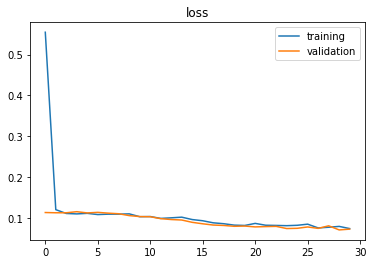

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')


In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>